# Установка и импорт библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproj

In [3]:
import pandas as pd
import numpy as np
import chromadb
import catboost
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Работа с данными

In [4]:
train_path = "/content/drive/MyDrive/Alfa FinU Hack/train_data.pqt".replace('\t', '')
train_df = pd.read_parquet(train_path)

In [5]:
train_df.isna().sum()

id                              0
date                            0
balance_amt_avg             65577
balance_amt_max             65577
balance_amt_min             65577
                            ...  
sum_cred_h_oper_3m              0
cnt_cred_h_oper_3m         165252
cnt_days_cred_h_oper_3m    165252
start_cluster                   0
end_cluster                     0
Length: 93, dtype: int64

##Мини анализ данных

кол-во классов

In [6]:
train_df['start_cluster'].value_counts()

start_cluster
{α}          375947
{}            78803
{α, η}        43824
{α, γ}        32790
{other}       31813
{α, β}         9869
{α, δ}         8537
{α, ε}         5843
{α, θ}         4968
{α, ψ}         3000
{α, μ}         1341
{α, ε, η}      1207
{α, ε, θ}       851
{α, λ}          739
{α, ε, ψ}       374
{λ}              69
{α, π}           25
Name: count, dtype: int64

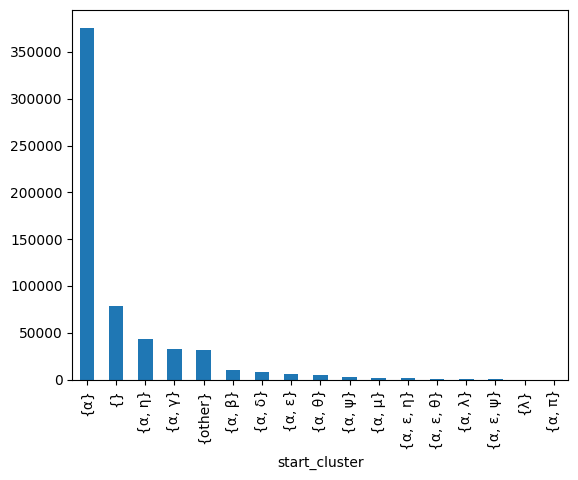

In [7]:
train_df['start_cluster'].value_counts().plot(kind='bar');

In [8]:
classes=train_df['end_cluster'].unique()
print(*classes)

{other} {α} {α, γ} {} {α, ε} {α, β} {α, η} {α, μ} {α, ψ} {α, λ} {α, δ} {α, θ} {α, ε, θ} {α, ε, ψ} {α, ε, η} {λ} {α, π}


##Обработка данных

###Переменные

In [9]:
#категориальные признаки
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]

In [10]:
#Столбцы для обработки некоторомыми фунциями (названия столбцов вынесены, чтобы пользователь мог регулировать обработку + если вы решите изменить название столбцов нужно будет это отобразить только здесь)
select_dict={
    'list_operations': ['cnt_a_oper_1m', 'cnt_b_oper_1m', 'cnt_c_oper_1m'],
    'list_incoming_operations':['cnt_cred_d_oper_1m', 'cnt_cred_e_oper_1m', 'cnt_cred_f_oper_1m', 'cnt_cred_g_oper_1m', 'cnt_cred_h_oper_1m'],#список входящих операций
    'list_outgoing_operations': ['cnt_deb_d_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_deb_g_oper_1m', 'cnt_deb_h_oper_1m'],#список исходящих операций
    'list_operations_summi':['sum_a_oper_1m', 'sum_b_oper_1m', 'sum_c_oper_1m']#список сумм A,B,C операций
}

список признаков для удаления

In [11]:
drop_list=['cnt_deb_g_oper_3m_3',
 'cnt_cred_g_oper_3m_3',
 'cnt_days_cred_g_oper_3m_3',
 'cnt_cred_h_oper_3m_3',
 'ogrn_days_end_quarter_mean',
 'cnt_b_oper_1m_mean',
 'sum_cred_d_oper_1m_mean',
 'cnt_days_cred_g_oper_1m_mean',
 'cnt_deb_d_oper_3m_mean',
 'cnt_cred_d_oper_3m_mean',
 'sum_cred_f_oper_3m_mean',
 'cnt_days_cred_f_oper_3m_mean',
 'cnt_a_oper_1m_sum',
 'cnt_b_oper_1m_sum',
 'sum_of_paym_2m_hide_1',
 'sum_of_paym_6m_hide_1',
 'sum_of_paym_1y_hide_1',
 'city_1',
 'sum_of_paym_1y_hide_2',
 'city_2',
 'city_type_2',
 'cnt_cred_f_oper_3m_2',
 'sum_of_paym_2m_hide_3',
 'sum_of_paym_6m_hide_3',
 'sum_of_paym_1y_hide_3',
 'city_type_3']

###Фунции для заполнения NaN значений

In [12]:
#самое простое заполнение NaN (не используется)
def simple_fill(df,cat_cols):
  val_cols = df.select_dtypes(include = ["int64", "float64"])
  #считаем среднее значение по столбцам для каждой группы
  #где не смогли посчитать среднее значение заменяем на 0
  df[val_cols.columns] = df[val_cols.columns].fillna(0)
  df.fillna('', inplace=True)
  return df

#заменяем все NaN в числовых столбцах на среднее значение по столбцам для каждой группы
def smart_fill_na(full_df, num_month):
  #берем только числовые столбцы
  df = full_df.select_dtypes(include = ["int64", "float64"])
  #считаем среднее значение по столбцам для каждой группы
  mean_df = (df.groupby('id').max() + df.groupby('id').min())/2
  #где не смогли посчитать среднее значение заменяем на 0
  mean_df = mean_df.reset_index().fillna(0)
  #дублируем строки несколько раз
  mean_df = mean_df.loc[mean_df.index.repeat(num_month)].reset_index(drop=True)
  #заменяем все NaN на среднее значение по столбцам для каждой группы
  mask_fill_na = df.isna()*mean_df
  #объединяем с исходной таблицой, так чтобы на месте всех NaN стояли средние значения по маске
  new_val_columns = df.fillna(0)+mask_fill_na

  #full_df.update(new_df)
  return new_val_columns



In [13]:
#заполнение пропущенных строк в тестовом датасете
def fill_spaces(test_df):
  month_count=len(test_df['date'].unique())
  users_count=len(test_df['id'].unique())

  rows = sorted(np.repeat(test_df['id'].unique(),month_count))
  columns = ['id', 'date']# test_df.columns
  dates=list(test_df['date'].unique())*users_count

  # Создание DataFrame с пустыми строками
  empty_df = pd.DataFrame('', index=range(len(rows)), columns=columns)
  empty_df['id']=rows
  empty_df['date']=dates

  # Заполнение пробелов в test_df
  merged_df = pd.merge(empty_df, test_df, on=['id', 'date'], how='left')
  return merged_df

In [14]:
#Создание векторной бд для поиска схожих строчек и заполнения пропусков
def create_db(good_df_arr):
  ids=[str(x) for x in range(len(good_df_arr))]
  client = chromadb.Client()
  print('good_df_arr:',good_df_arr.shape)

  try:
    client.delete_collection(name="all-my-documents")
  except:
    pass
  collection = client.create_collection("all-my-documents")

  collection.add(
      embeddings=good_df_arr,
      ids=ids
  )
  return collection

#Ищет похожих пользователей в базе данных (эмбединги пользователей состоят из числовых признаков, и чем они ближе - тем ближе пользователи)
def get_simularity_samples(collection,bad_rows_arr):


  print('bad_rows_arr:',bad_rows_arr.shape)
  results = collection.query(
      query_embeddings=bad_rows_arr,
      n_results=2,

  )
  return results


In [15]:
#заполняет пустые числовые и категориальные значения
def preprocessing_min(df, cat_cols, num_month):
  #заполнение пустых числовых значений
  new_val_columns=smart_fill_na(df, num_month)
  df.update(new_val_columns)

  df[cat_cols] = df[cat_cols].fillna('')
  #заполнение пустых категориальных значений
  df[cat_cols] = df[cat_cols].astype("category")
  return df

#заполнять нулями значения, которые мы не смогли заполнить на прошлом этапе
def preprocessing_simularity_fill(input_df, df_db):
  df=input_df
  df_for_db=df_db

  df = df.drop('id', axis=1)
  #берем только числовые столбцы
  df = df.select_dtypes(include = ["int64", "float64"])

  df_for_db = df_for_db.drop('id', axis=1)
  #берем только числовые столбцы
  df_for_db = df_for_db.select_dtypes(include = ["int64", "float64"])

  #Находим идеальные строчки (сточки без единого NaN)
  df.replace(0, np.nan, inplace=True)
  df_for_db.replace(0, np.nan, inplace=True)

  df_for_fill=df
  good_df=df_for_db.dropna(axis=0)


  #берем заданное количество идеальных строчек
  good_df=good_df.sample(40000)
  good_df_arr=np.array(good_df.values)


  #берем строки, в которых содержится NaN
  bad_rows=df_for_fill[df_for_fill.isna().any(axis=1)]
  bad_rows_arr=bad_rows.fillna(0)
  index_list = bad_rows_arr.index.tolist()
  bad_rows_arr = np.array(bad_rows_arr.values)

  #для каждой строки с пропущеным значением находим схожую
  collection = create_db(good_df_arr)
  results=get_simularity_samples(collection,bad_rows_arr)
  #жадно берем самую ближайшую строку из идеальных строк для каждой плохой строки
  idx=np.array(results['ids'])[:, 0]
  good_values_df = good_df.iloc[idx]


  #Заменяем все NaN значения из плохих строк на значения (стоящие в том же столбце) из идеальных строк. И так для кажой плохой строки
  bad_rows_idxs=bad_rows.index.tolist()
  good_values_df=good_values_df.set_index(pd.Index(bad_rows_idxs))
  good_values_df.replace(0, np.nan, inplace=True)
  good_values_df=good_values_df.dropna(axis=0)
  bad_rows=bad_rows.fillna(good_values_df)


  #Встраивание обработанных строк в исходную таблицу
  input_df.update(bad_rows)
  return input_df

###Фунции для генерации фичей

In [16]:
#считает среднее значение по всем числовы характеристикам среди месяцев
def meaning(df):
  new_df = df.select_dtypes(include = ["int64", "float64"])
  new_df['id']=df['id']
  new_df = new_df.groupby("id").mean(numeric_only = True)

  #переименовка признаков
  rename_dict={}
  for name in new_df.columns:
    rename_dict[name]=f'{name}_mean'
  new_df.rename(columns=rename_dict, inplace=True)

  return new_df

#создание подпоследовательностей для каждого пользователя
def do_sublist(df, windows):
  # Получаем подсписки
  sublists = [group.tolist() for group in df['start_cluster'].rolling(window=windows)]

  # Убираем первые windows - 1 элементов, так как они содержат NaN и делаем срез шагом windows
  sublists = sublists[windows-1:]
  sublists = sublists[::windows]
  return sublists

#считает очень быстро, но не точно
def light_check_change_clusters(df):
  unique_counts = df.groupby('id')['start_cluster'].nunique()-1
  unique_counts.name='change_clusters'
  return unique_counts

#подсчет сколько раз пользователь менял свой кластер
def check_change_clusters(df, month_to_predict, light_varsion = True):
  #Избавляемся от месяца для предсказаний и сохраняем в список столбец id
  df = df.drop(df[df['date'] == month_to_predict].index)

  if light_varsion : return light_check_change_clusters(df)

  id_pole = list(df['id'])

  #Вызов функции для разбития start_cluster на подсписки
  sublists = do_sublist(df, 2)

  #формируем словарь из кластеров продуктов и булевых значений чтобы понять менел ли пользователь свой продукт при переходе в новый месяц
  dict_start_cluster = {'cluster':[k for group in sublists for k in group], 'change_clusters':[]}

  #Заполняем словарь булевых значений
  for group in sublists:
    for i in range(0, len(group)-1):
      if group[i] != group[i+1]:
        dict_start_cluster['change_clusters'].append(True)
      else:
        dict_start_cluster['change_clusters'].append(False)
    dict_start_cluster['change_clusters'].append(False)

  #Формируем DataFrame из словаря
  df = pd.DataFrame.from_dict(dict_start_cluster)
  df['id'] = id_pole

  df= df.groupby('id')['change_clusters'].sum()

  #df= df['change_clusters'].apply(str).astype("category")
  return df


def rename_columns(old_names, idx_month):
  new_names={}
  for old_name in old_names:
    new_names[old_name]=old_name+"_"+str(idx_month)
  return new_names

#Объедениение всех месяцев в одну строку
def concat_names(df, test_mode, num_month):

  if test_mode:
    start_month=num_month+1
    drop_arr=['date']
    return pd.concat([df[df['date']==f'month_{x}'].set_index('id').drop(drop_arr, axis=1).rename(rename_columns(df.columns, x-num_month), axis=1) for x in range(start_month, start_month+num_month)], axis=1)
  else:
    drop_arr=['date', 'end_cluster']
    start_month=1
    return pd.concat([df[df['date']==f'month_{x}'].set_index('id').drop(drop_arr, axis=1).rename(rename_columns(df.columns, x), axis=1) for x in range(start_month, start_month+num_month)], axis=1)

  return new_df

def drop_useless_columns(new_df, df, num_month):
  new_df = new_df.drop([f'start_cluster_{num_month}'], axis=1)
  return new_df

#смотрит скрывает ли клиент статистику по определеннвм столбцам
def check_hide_payment(df):
  list_of_payment=['sum_of_paym_2m','sum_of_paym_6m','sum_of_paym_1y']
  rename_dict={}
  for x in list_of_payment:
    rename_dict[x]=f'{x}_hide'
  hide_payment = df[list_of_payment]==0
  hide_payment = hide_payment.rename(rename_dict, axis=1)
  #hide_payment['id']=df['id']
  return hide_payment





In [17]:
#подсчет кол-ва операций A,B,C за месяца и их общее кол-во
def sum_abc(df, list_operations):
  dict_for_column={old:f'{old}_sum' for old in list_operations}
  list_operations2 = list(dict_for_column.keys())
  list_operations2.append('id')
  df = df[list_operations2]


  #Подсчет суммы количества операций за месяца
  new_dff = df.groupby('id').sum().rename(dict_for_column, axis=1)

  #Сумма abc
  new_dff['sum_operations'] = new_dff[new_dff.columns].sum(axis=1)

  return new_dff

def sum_incoming_operations(df, list_incoming_operations):
  #Создание словаря для смены названия колонок
  dict_for_column={old:f'{old}_sum' for old in list_incoming_operations}
  list_incoming_operations2 = list(dict_for_column.keys())
  list_incoming_operations2.append('id')
  df = df[list_incoming_operations2]

  #Подсчет суммы количества входящих операций за 3 месяца
  df = df.groupby('id').sum().rename(dict_for_column, axis=1)

  #Подсчет суммы количества входящих операций D,E,F,G,H
  df['sum_incoming_operations'] = df[df.columns].sum(axis=1)
  return df

def sum_outgoing_operations(df, list_outgoing_operations):
  #Создание словаря для смены названия колонок
  dict_for_column={old:f'{old}_sum' for old in list_outgoing_operations}
  list_outgoing_operations2 = list(dict_for_column.keys())
  list_outgoing_operations2.append('id')
  df = df[list_outgoing_operations2]

  #Подсчет суммы количества входящих операций за 3 месяца
  df = df.groupby('id').sum().rename(dict_for_column, axis=1)

  #Подсчет суммы количества исходящих операций D,E,F,G,H
  df['sum_outgoing_operations'] = df[df.columns].sum(axis=1)
  return df

#Подсчет суммы сумм операций A,B,C
def sum_operations_summi(df, list_operations_summi):
  #Создание словаря для смены названия колонок
  dict_for_column={old:f'{old}_sum' for old in ['sum_a_oper_1m', 'sum_b_oper_1m', 'sum_c_oper_1m']}
  list_incoming_operations2 = list(dict_for_column.keys())
  list_incoming_operations2.append('id')
  df = df[list_incoming_operations2]

  #Подсчет суммы суммы A,B,C операций за 3 месяца
  dff = df.groupby('id').sum().rename(dict_for_column, axis=1)

  #Подсчет суммы суммы A,B,C операций
  dff['sum_operations_summi'] = dff[dff.columns].sum(axis=1)
  return dff

def ratio_of_summi_to_sum_operations(df):
  sum_operations_summi = df['sum_operations_summi'].values
  sum_operations = df['sum_operations'].values

  ratios = np.where(sum_operations != 0, sum_operations_summi / sum_operations, 0)

  return pd.DataFrame(ratios, columns=['ratio_of_summi_to_sum_operations'])

#Отношение входящих к исходящим операциям
def ratio_of_incoming_to_outgoin_operations(df):
  return pd.DataFrame(df.apply(lambda row: row['sum_incoming_operations'] / row['sum_outgoing_operations'] if row['sum_outgoing_operations'] != 0 else 0, axis=1), columns=['ratio_incoming_to_outgoin_operations'])

#Отношение sum_cred_e_oper_1m к sum_deb_h_oper_1m
def ratio_cred_e_to_deb_h(df):
  return pd.DataFrame(df.apply(lambda row: row['sum_cred_e_oper_1m_mean'] * row['sum_deb_h_oper_1m_1'], axis=1), columns=['sum_cred_e_oper_1m_mean * sum_deb_h_oper_1m_1'])

#Отношение min_founderpres к max_founderpres
def ratio_minfound_to_maxfound(df):
  return pd.DataFrame(df.apply(lambda row: row['min_founderpres_1'] / row['max_founderpres_1'] if row['max_founderpres_1'] != 0 else 0, axis=1), columns=['min_founderpres_1 / max_founderpres_1'])

In [18]:
#выполнение различных операций над некоторыми столбцами
def analise_operations(df, new_df, select_dict):

  #подсчет кол-ва операций A,B,C за месяца и их общее кол-во
  new_df = pd.concat((new_df, sum_abc(df, select_dict['list_operations'])), axis=1)

  #подсчет исходящих кол-ва операций D,E,F,G,H за месяца и их общее кол-во
  new_df = pd.concat((new_df, sum_incoming_operations(df, select_dict['list_incoming_operations'])), axis=1)

  #подсчет входящих кол-ва операций D,E,F,G,H за месяца и их общее кол-во
  new_df = pd.concat((new_df, sum_outgoing_operations(df, select_dict['list_outgoing_operations'])), axis=1)

  #подсчет суммы сумм операций A,B,C за месяца и их общая сумма
  new_df = pd.concat((new_df,sum_operations_summi(df, select_dict['list_operations_summi'])), axis=1)

  #Подсчет отношения входящих к исходящим операциям
  new_df = pd.concat((new_df, ratio_of_incoming_to_outgoin_operations(new_df)), axis=1)

  #Подсчет отношения суммы A,B,C к кол-ву операции A,B,C
  new_df = pd.concat((new_df, ratio_of_summi_to_sum_operations(new_df)), axis=1)

  new_df = pd.concat((new_df, ratio_cred_e_to_deb_h(new_df)), axis=1)

  new_df = pd.concat((new_df, ratio_minfound_to_maxfound(new_df)), axis=1)
  return new_df

In [19]:
#Отношение минимального к среднему остатку на счету
def ratio_of_min_to_avg_operations(df):
  return pd.DataFrame(df.apply(lambda row: row['balance_amt_min'] / row['balance_amt_avg'] if row['balance_amt_avg'] != 0 else 0, axis=1), columns=['ratio_of_min_to_avg_operations'])

#Отношение максимального к среднему остатку на счету
def ratio_of_max_to_avg_operations(df):
  return pd.DataFrame(df.apply(lambda row: row['balance_amt_max'] / row['balance_amt_avg'] if row['balance_amt_avg'] != 0 else 0, axis=1), columns=['ratio_of_max_to_avg_operations'])



##pipeline добавления всех фитч

pipeline добавление всех фитч

In [20]:
#фунция, объеденяющая остальные функции обработки и генерации фич
def make_features(df, df_for_db, month_to_predict, cat_cols, select_dict, test_mode=False):

  #кол-во месяцев для анализа
  num_month=len(list(df['date'].unique()))

  #заполнение пустых значений среднним значением по пользователю: считаем среднее значение по столбцам для каждой группы, где не смогли посчитать среднее значение заменяем на 0
  df = preprocessing_min(df, cat_cols, num_month)
  #df_for_db = preprocessing_min(df_for_db, cat_cols, num_month) - раскоментируйте, если хотите использовать бд для заполнения значений NaN значениям схожих пользователей (таких 2 строки)

  #смотрит скрывает ли клиент статистику по определеннвм столбцам
  df_1 = check_hide_payment(df)

  #заполнение пустых  значений значениеми со схожих строк
  #df = preprocessing_simularity_fill(df, df_for_db) - раскоментируйте, если хотите использовать бд для заполнения значений NaN значениям схожих пользователей (таких 2 строки)


  df = pd.concat((df_1, df), axis=1)

  #Объедениение всех месяцев в одну строку
  new_df = concat_names(df,test_mode,num_month)

  #считает среднее значение по всем числовы характеристикам среди 3 месяцев
  new_df = pd.concat((new_df,meaning(df)), axis=1)

  #подсчет сколько раз пользователь менял свой кластер
  new_df = pd.concat((new_df,check_change_clusters(df, month_to_predict, light_varsion=True)), axis=1)

  #подсчет кол-ва операций A,B,C за 3 месяца и их общее кол-во
  new_df = pd.concat((new_df, sum_abc(df, select_dict['list_operations'])), axis=1)

  #выбрасывание столбца start_cluster для последнего месеца
  new_df = drop_useless_columns(new_df, df, num_month)



  if not test_mode : new_df['end_cluster']=df[df['date']==month_to_predict][['end_cluster', 'id']].set_index('id')

  #удаление лишних признаков
  try:
    new_df = new_df.drop(drop_list, axis=1)
  except:
    print('Столбцы для удаления не найдены в датафрейме. Обновите список drop_list')

  return new_df

In [21]:
#выравнивание кол-ва экземпляров класса по определенному числу (дальше это нужно для генерации базы данных)
def equalize_classes2(df, classes, cut_value=20000):
    counts_class = df['end_cluster'].value_counts()
    new_df = pd.DataFrame()

    for class_ in classes:
        all_samples_class = df[df['end_cluster'] == class_]

        if counts_class[class_] > cut_value:
            new_df = pd.concat([new_df, all_samples_class.sample(cut_value, replace=True)], ignore_index=True)
        else:
            new_df = pd.concat([new_df, all_samples_class.sample(cut_value, replace=True)], ignore_index=True)

    return new_df

Обработка датасета

In [22]:
classes=train_df['end_cluster'].unique()
classes

array(['{other}', '{α}', '{α, γ}', '{}', '{α, ε}', '{α, β}', '{α, η}',
       '{α, μ}', '{α, ψ}', '{α, λ}', '{α, δ}', '{α, θ}', '{α, ε, θ}',
       '{α, ε, ψ}', '{α, ε, η}', '{λ}', '{α, π}'], dtype=object)

In [23]:
#напишите месяц для которого хотите предсказывать end_cluster
month_to_predict='month_3'

In [24]:
#Создает балансированную выборку из классов (служит для заполнения бд)
df_db= equalize_classes2(train_df,classes)

In [25]:

#заполнение фичами
train_df = make_features(train_df.copy(),df_db.copy(), month_to_predict, cat_cols, select_dict)

##Подготовка данных для обучения

Разделение датасета

In [26]:
df_train, df_val = train_test_split(train_df,test_size=0.2,random_state=42)
#del train_df

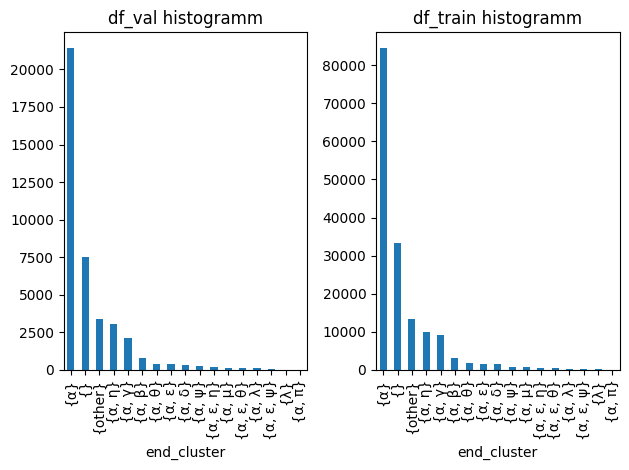

In [27]:
plt.subplot(1, 2, 1)
df_val['end_cluster'].value_counts().plot(kind='bar')
plt.title("df_val histogramm")
plt.subplot(1, 2, 2)
df_train['end_cluster'].value_counts().plot(kind='bar')
plt.title("df_train histogramm")
plt.tight_layout()  # Этот метод позволяет избежать наложения элементов графиков
plt.show()

Веса классов

In [28]:
cluster_path = "/content/drive/MyDrive/Alfa FinU Hack/cluster_weights.xlsx".replace('\t', '')
cluster_weights = pd.read_excel(cluster_path).set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [29]:
#функция для изменения весов классам
def transform_weight(weights_dict, koef):
  new_weights_dict={}
  for key, val in weights_dict.items():
    new_weights_dict[key]=val*koef
  return new_weights_dict

In [30]:
weights_dict = transform_weight(weights_dict, 1)
weights_dict

{'{}': 1,
 '{α, ε, η}': 1,
 '{α, ε, θ}': 1,
 '{α, θ}': 1,
 '{α, π}': 1,
 '{α, ε}': 2,
 '{α, η}': 2,
 '{α, μ}': 2,
 '{α}': 2,
 '{λ}': 2,
 '{other}': 3,
 '{α, β}': 3,
 '{α, γ}': 3,
 '{α, δ}': 3,
 '{α, ε, ψ}': 3,
 '{α, λ}': 3,
 '{α, ψ}': 3}





# Работа с моделью

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153248 to 121958
Columns: 339 entries, balance_amt_avg_1 to end_cluster
dtypes: bool(2), category(22), float64(313), int64(1), object(1)
memory usage: 390.8+ MB


Подготовка данных

In [32]:
auxiliary_columns = ["date"]
cat_features = list(df_train.select_dtypes(include=['category']).columns)

In [33]:
#словари для перевод класса в число и наоборот
n2c={}
c2n={}
for i, class_ in enumerate(classes):
  n2c[i]=class_
  c2n[class_]=i

In [34]:
def class_to_num(s):
  s=[c2n[x] for x in s]
  return s

def preprocess_data_part(data_part, c2n_bool = False):
    #data_part = data_part.drop(auxiliary_columns, axis=1)

    X = data_part.drop(['end_cluster'], axis=1)
    y = data_part['end_cluster']
    if c2n_bool : y = class_to_num(y)
    return X, y

X_train, y_train = preprocess_data_part(df_train)
X_val, y_val = preprocess_data_part(df_val)



In [35]:
X_train.sample(3)

,balance_amt_avg_1,balance_amt_max_1,balance_amt_min_1,balance_amt_day_avg_1,channel_code_1,city_type_1,index_city_code_1,ogrn_days_end_month_1,ogrn_days_end_quarter_1,ogrn_month_1,...,cnt_days_cred_g_oper_3m_mean,sum_deb_h_oper_3m_mean,cnt_deb_h_oper_3m_mean,cnt_days_deb_h_oper_3m_mean,sum_cred_h_oper_3m_mean,cnt_cred_h_oper_3m_mean,cnt_days_cred_h_oper_3m_mean,change_clusters,cnt_c_oper_1m_sum,sum_operations
id,,,,,,,,,,,,,,,,,,,,,
122770,-0.152449,-0.174258,-0.125994,-0.151972,channel_code_6,city_type_0,,-1.417577,-1.645024,ogrn_month_3,...,0.384773,0.683267,0.557874,0.974354,-0.113754,0.252368,0.429485,0,1.652394,4.211444
37832,0.030722,0.180408,-0.011874,0.031766,channel_code_2,city_type_0,index_city_code_3,0.672727,1.413615,ogrn_month_7,...,0.476727,-0.122667,0.549803,0.481761,0.072040,0.252849,0.440474,0,1.657660,4.277458
152821,-0.155339,-0.204242,-0.124802,-0.154871,channel_code_21,city_type_0,index_city_code_34,0.092087,0.058522,ogrn_month_4,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,1,0.000000,0.000000


Преобразование датасетов к catboost формату

In [36]:
from catboost import Pool

train_pool = Pool(
    X_train, y_train,
    cat_features=cat_features,
)

validation_pool = Pool(
    X_val, y_val,
    cat_features=cat_features,
)


##Обучение

In [37]:
from catboost import CatBoostClassifier
def fit_model(train, validation_pool, grow_policy="SymmetricTree", **kwargs):
    model = CatBoostClassifier(
        class_weights=weights_dict,#list_of_weights,
        iterations=10000,
        learning_rate=0.05,
        loss_function="MultiClass",
        eval_metric='AUC',
        task_type='GPU',
        train_dir='train',
        early_stopping_rounds=1000,
        grow_policy = grow_policy,#"SymmetricTree" #Depthwise #Lossguide
        **kwargs
    )
    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=500,
    )


In [38]:
model1 = fit_model(train_pool, validation_pool, grow_policy="SymmetricTree")
model2 = fit_model(train_pool, validation_pool, grow_policy="Depthwise")

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8272341	best: 0.8272341 (0)	total: 173ms	remaining: 28m 46s
500:	test: 0.9431234	best: 0.9437973 (437)	total: 59.2s	remaining: 18m 42s
1000:	test: 0.9439775	best: 0.9443581 (940)	total: 2m 10s	remaining: 19m 29s
1500:	test: 0.9431478	best: 0.9450787 (1118)	total: 3m 10s	remaining: 17m 56s
2000:	test: 0.9399961	best: 0.9450787 (1118)	total: 4m 9s	remaining: 16m 37s
bestTest = 0.9450786883
bestIteration = 1118
Shrink model to first 1119 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8029137	best: 0.8029137 (0)	total: 323ms	remaining: 53m 46s
500:	test: 0.9349321	best: 0.9379381 (146)	total: 59.5s	remaining: 18m 48s
1000:	test: 0.9368073	best: 0.9387533 (612)	total: 1m 55s	remaining: 17m 14s
1500:	test: 0.9407978	best: 0.9410905 (1438)	total: 2m 50s	remaining: 16m 6s
2000:	test: 0.9395477	best: 0.9411912 (1525)	total: 3m 47s	remaining: 15m 9s
2500:	test: 0.9408038	best: 0.9411912 (1525)	total: 4m 45s	remaining: 14m 16s
bestTest = 0.9411911643
bestIteration = 1525
Shrink model to first 1526 iterations.


In [39]:
model1.predict(validation_pool, prediction_type="Probability")
model2.predict(validation_pool, prediction_type="Probability")

array([[6.30285942e-04, 7.97924951e-05, 3.51854717e-04, ...,
        1.53044301e-04, 2.80069678e-03, 7.08501727e-04],
       [6.51112987e-04, 6.30190483e-05, 1.08697239e-03, ...,
        1.50639141e-04, 7.06146965e-03, 3.93345134e-04],
       [9.59120141e-04, 2.06012057e-04, 9.94993647e-04, ...,
        6.46967927e-04, 9.98722310e-03, 2.82977627e-03],
       ...,
       [3.53308210e-02, 3.01593425e-03, 3.14153725e-04, ...,
        6.55726955e-05, 1.45509693e-04, 4.62794352e-04],
       [1.61492311e-03, 9.25649771e-03, 1.46035548e-04, ...,
        4.16672791e-05, 7.94675261e-05, 5.55602658e-05],
       [6.43485396e-03, 8.47429588e-05, 6.67127659e-04, ...,
        1.44113704e-04, 1.53498543e-03, 2.29052971e-03]])

###Подсчет важности фичей

In [40]:
importances = model1.get_feature_importance(type='PredictionValuesChange')#[:20]
feature_importances = pd.Series(importances, index=X_val.columns).sort_values().iloc[len(X_val.columns)-20:]

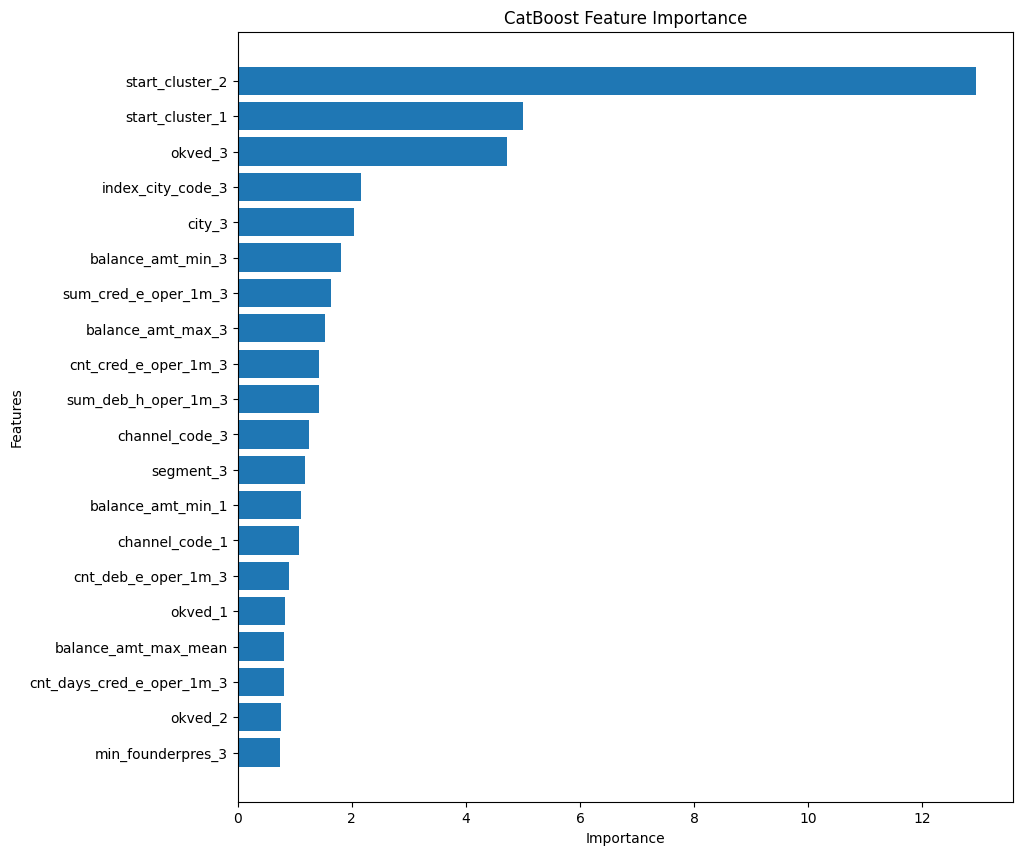

In [41]:
plt.figure(figsize=(10, 10));
plt.barh(feature_importances.index, feature_importances.values);
plt.title('CatBoost Feature Importance');
plt.xlabel('Importance');
plt.ylabel('Features');

# Прогноз на тестовой выборке

In [42]:
test_path = '/content/drive/MyDrive/Alfa FinU Hack/test_data.pqt'.replace('\t', ' ')
test_df = pd.read_parquet(test_path)


test_df = fill_spaces(test_df)

In [43]:
month_to_predict_test='month_6'
test_df = make_features(test_df.copy(),df_db.copy(), month_to_predict_test, cat_cols,select_dict, test_mode=True)

In [44]:
test_df.sample(3)

,balance_amt_avg_1,balance_amt_max_1,balance_amt_min_1,balance_amt_day_avg_1,channel_code_1,city_type_1,index_city_code_1,ogrn_days_end_month_1,ogrn_days_end_quarter_1,ogrn_month_1,...,cnt_days_cred_g_oper_3m_mean,sum_deb_h_oper_3m_mean,cnt_deb_h_oper_3m_mean,cnt_days_deb_h_oper_3m_mean,sum_cred_h_oper_3m_mean,cnt_cred_h_oper_3m_mean,cnt_days_cred_h_oper_3m_mean,change_clusters,cnt_c_oper_1m_sum,sum_operations
id,,,,,,,,,,,,,,,,,,,,,
253742,-0.156758,-0.204935,-0.125995,-0.156295,channel_code_21,city_type_0,,-1.185321,-0.367365,ogrn_month_0,...,0.396267,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,0,1.652394,4.211444
257951,-0.156256,-0.204571,-0.125995,-0.155791,channel_code_5,,index_city_code_103,1.834007,1.800784,ogrn_month_2,...,0.000000,-0.165588,0.000000,0.000000,-0.201123,0.000000,0.000000,0,0.000000,0.000000
245552,-0.121764,-0.154787,-0.098548,-0.121192,channel_code_2,city_type_0,,-0.256297,-0.057629,ogrn_month_0,...,0.568681,-0.140793,0.549468,0.589169,-0.086951,0.254775,0.513734,0,1.652394,4.211444


Делаем прогноз

In [45]:
test_pred1 = model1.predict(test_df, prediction_type="Probability")
test_pred2 = model2.predict(test_df, prediction_type="Probability")

test_pred1 = pd.DataFrame(test_pred1, columns=model1.classes_)
test_pred2 = pd.DataFrame(test_pred2, columns=model2.classes_)

sorted_classes = sorted(test_pred1.columns.to_list())


In [48]:
submission = pd.read_csv("/content/drive/MyDrive/Alfa FinU Hack/sample_submission.csv")
for i in range(0, 101, 10):
  a = round(i/100, 2)
  b = round(1-a, 2)
  test_result = test_pred1 * a + test_pred2 * b
  test_pred_proba_df = test_result[sorted_classes]
  submission[sorted_classes] = test_pred_proba_df
  name_of_submission = "submission" + f"_{a}_a+{b}_b_option" +".csv"
  submission.to_csv(name_of_submission, index=False)
